In [3]:
# this code takes the NFIRS Dataset and the Station_locations dataset and outputs 
# requires NFIRS_2009_2016.csv and Station_location.csv to be in the main path 

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [5]:
# Change to your filepath to data and uncomment if NFIRS_2009_2016.csv not in the main path 
os.chdir('..\Data\Raw')

In [45]:
NFIR = pd.read_csv('NFIRS_2009_2016_geocoded_with_tract.csv',
                   encoding='latin_1',
                   index_col=0,
                   low_memory=False)

STATION = pd.read_csv('Fire_stations.csv',
                   index_col=0,
                   low_memory=False)

In [8]:
def haversine(lat1,long1,lat2,long2):
    earth_radius_miles = 3959
    lat1, long1, lat2, long2 = map(np.deg2rad, [lat1, long1, lat2, long2])
    dlat = lat2 - lat1 
    dlong = long2 - long1
    # haversine formula 
    hav_theta = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2
    theta = 2 * np.arcsin(np.sqrt(hav_theta)) 
    #  Arc Distance  = Angle * Radius  
    total_miles = earth_radius_miles * theta   
    return total_miles

In [46]:
# Data Cleaning 
 
NFIR = NFIR[['STATE','X','Y']] 
NFIR = NFIR[~NFIR['X'].isnull()]
NFIR = NFIR[NFIR.STATE.str.match('[A-Z]{2}')]

# from NFIR_geocode_cleaner- swaps x,y data if it is found to be outside the Lat/Long of the US,
# under the assumption that with said data the x,y values were reversed.  
NFIR[['X','Y']] = NFIR[['Y','X']].where( (NFIR['X'] > 0) & (NFIR['Y'] < 0), NFIR[['X','Y']].values )



STATION = STATION[['ID','STATE','X','Y']]

In [10]:
STATION['STATE'].value_counts()

CA    3209
NY    2851
TX    2714
PA    2708
NC    1947
GA    1899
IL    1847
OH    1810
FL    1746
MO    1578
AL    1541
MI    1490
TN    1410
AR    1346
LA    1321
NJ    1296
WA    1268
IN    1233
OK    1203
KY    1194
SC    1113
WI    1076
VA    1025
MS    1010
KS     998
MN     987
CO     928
IA     860
MA     815
OR     731
NM     639
AZ     602
CT     585
WV     573
NE     564
ME     549
MD     510
MT     478
ID     397
SD     387
AK     352
UT     349
ND     348
NH     326
VT     268
NV     261
WY     214
RI     164
HI     108
DE      90
PR      84
DC      37
GU      24
VI      13
MP       9
AS       2
Name: STATE, dtype: int64

In [11]:
def closest_firestation(fires,stations):
    print("Running {}".format( fires['STATE'].unique() ) )
    distance =  haversine(   fires['X'].values.reshape(1,-1),    fires['Y'].values.reshape(1,-1),
                          stations['X'].values.reshape(-1,1), stations['Y'].values.reshape(-1,1))
    
    # find minimum distance and their row indicies 
    
    min_dist = distance.min(axis = 0)
    
    row_idx =  distance.argmin(axis = 0 ) 
    
    # use row indicies to find STATION IDs
    closest = list(stations.iloc[row_idx,0])
    
    # create the closest station (CS) dataframe and return it 
    CS =  pd.DataFrame( data = {'CLOSEST_STATION_ID':closest,'CLOSEST_STATION_MILES':min_dist }, index = fires.index  )
    return CS 


In [12]:
# Timing the largest state to see how long this will take.
#%%timeit
#state = 'CA'
#CS = closest_firestation(NFIR[ NFIR['STATE'] == state ],
#                         STATION[ STATION['STATE'] == state] )
 

IndentationError: unexpected indent (<ipython-input-12-60eeb96a2794>, line 5)

In [13]:
 CS =  pd.concat( [closest_firestation(NFIR[NFIR['STATE'] == state],
                                      STATION[STATION['STATE']== state]) for state in NFIR['STATE'].unique() ] )

Running ['AL']
Running ['CA']
Running ['AR']
Running ['AK']
Running ['AZ']
Running ['FL']
Running ['CT']
Running ['DE']
Running ['CO']
Running ['DC']
Running ['GA']
Running ['IA']
Running ['HI']
Running ['IL']
Running ['ID']
Running ['KS']
Running ['IN']
Running ['KY']
Running ['MA']
Running ['LA']
Running ['MD']
Running ['MI']
Running ['ME']
Running ['MN']
Running ['MO']
Running ['NC']
Running ['MS']
Running ['MT']
Running ['NJ']
Running ['NE']
Running ['NH']
Running ['ND']
Running ['NV']
Running ['NM']
Running ['NY']
Running ['OH']
Running ['OR']
Running ['PA']
Running ['OK']
Running ['SD']
Running ['RI']
Running ['SC']
Running ['TN']
Running ['TX']
Running ['VA']
Running ['UT']
Running ['WA']
Running ['WI']
Running ['VT']
Running ['WV']
Running ['WY']


In [23]:
CS.head()

,CLOSEST_STATION_ID,CLOSEST_STATION_MILES
ID,,
rcp2_id1869,10522050,0.272937
rcp2_id1861,10501984,0.364839
rcp2_id1862,10502051,0.437141
rcp2_id1865,10142198,0.939515
rcp2_id1867,10522050,0.413671


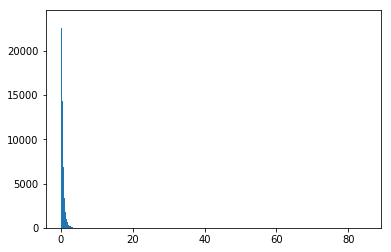

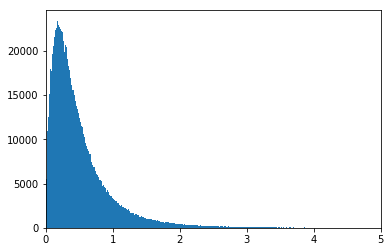

In [29]:
plt.hist(CS ['CLOSEST_STATION_MILES'],bins= 10000 )
plt.show()
plt.hist(CS ['CLOSEST_STATION_MILES'],bins= 10000 )
plt.xlim([0, 5])
plt.show()

Output

In [30]:
CS.to_csv('..\Transformed\Closest_Firestation')

In [49]:
## Verification 


In [50]:
# manual validation that the STATION_ID  that was selected for each experiment is the correct distance away
NFIR = NFIR.merge(CS, how= 'left', left_on='ID',right_on='ID')
test = NFIR.merge(STATION[['ID','X','Y']],how= 'left',left_on= 'CLOSEST_STATION_ID',right_on='ID' )

Calculated = haversine(test['X_x'],test['Y_x'],test['X_y'],test['Y_y'])
sum(Calculated - NFIR['CLOSEST_STATION_MILES'].values) < 1e-10


True

In [ ]:

# TO-DO
#1. discriptive statistics by state/county/tract. Mean dist, avg dist, max dist
#2. replicate this methodology to Find tracts that are far away from fire stations
#3. 